In [1]:
import numpy as np
import pandas as pd

import os
import matplotlib.pyplot as plt
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
banana=pd.read_csv(r"C:\Users\MAYANK KUMAR\OneDrive\Desktop\OneDrive - K.R. MANGALAM UNIVERSITY\Banana.csv")
banana[0:3]

,Price Date,States,Commodity,Modal Price (Rs./Quintal)
0,14 Jul 2020,Delhi,Banana,1550
1,13 Jul 2020,Delhi,Banana,1500
2,11 Jul 2020,Delhi,Banana,1500


In [3]:
n=len(banana)
data=banana[0:(n//10)*9]
test_data=banana[(n//10)*9:]

In [4]:
test_data[0:3]

,Price Date,States,Commodity,Modal Price (Rs./Quintal)
1674,02 Sep 2014,Delhi,Banana,1201
1675,01 Sep 2014,Delhi,Banana,1200
1676,30 Aug 2014,Delhi,Banana,1150


In [5]:
print(len(data))
print(len(test_data))

1674
187


In [6]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Modal Price (Rs./Quintal)'].values.reshape(-1,1))

In [7]:
prediction_days = 100

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x - prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [8]:
print(x_train.shape)
print(y_train.shape)

(1574, 100, 1)
(1574,)


In [9]:
def LSTM_model():
    
    model = Sequential()    
    model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1],1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 50))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    
    return model

In [10]:
model = LSTM_model()
model.summary()
model.compile(optimizer='adam', loss='mean_squared_error')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 dropout_1 (Dropout)         (None, 100, 50)           0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

In [11]:
checkpointer = ModelCheckpoint(filepath = 'weights_best.hdf5', verbose = 1, save_best_only = True)
model.fit(x_train, y_train, epochs=10, batch_size = 32,callbacks = [checkpointer])

Epoch 1/10
50/50 [==============================] - 13s 124ms/step - loss: 0.0299
Epoch 2/10
50/50 [==============================] - 6s 123ms/step - loss: 0.0133
Epoch 3/10
50/50 [==============================] - 5s 105ms/step - loss: 0.0125
Epoch 4/10
50/50 [==============================] - 6s 119ms/step - loss: 0.0112
Epoch 5/10
50/50 [==============================] - 6s 113ms/step - loss: 0.0103
Epoch 6/10
50/50 [==============================] - 6s 116ms/step - loss: 0.0098
Epoch 7/10
50/50 [==============================] - 6s 120ms/step - loss: 0.0100
Epoch 8/10
50/50 [==============================] - 6s 117ms/step - loss: 0.0091
Epoch 9/10
50/50 [==============================] - 5s 100ms/step - loss: 0.0089
Epoch 10/10
50/50 [==============================] - 5s 109ms/step - loss: 0.0085


In [12]:
actual_prices = test_data['Modal Price (Rs./Quintal)'].values
total_dataset = pd.concat((data['Modal Price (Rs./Quintal)'], test_data['Modal Price (Rs./Quintal)']), axis=0)

model_inputs = total_dataset[len(total_dataset)-len(test_data)-prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

In [13]:
x_test = []
for x in range(prediction_days,len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x,0])

x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

6/6 [==============================] - 2s 37ms/step


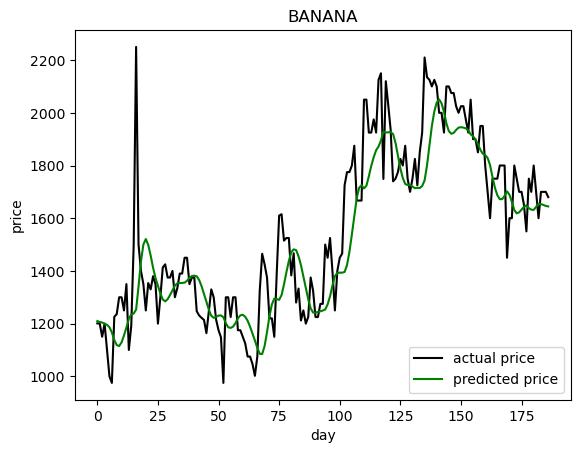

In [14]:
plt.plot(actual_prices, color='black', label=f"actual price")
plt.plot(predicted_prices, color= 'green', label=f"predicted price")
plt.title(f"BANANA")
plt.xlabel("day")
plt.ylabel(f"price")
plt.legend()
plt.show()

In [15]:
real_data = [model_inputs[len(model_inputs)+1-prediction_days:len(model_inputs+1),0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data,(real_data.shape[0],real_data.shape[1],1))
print(real_data.shape)

(1, 99, 1)


In [16]:
prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f"prediction: {prediction}")

1/1 [==============================] - 2s 2s/step
prediction: [[1642.5303]]
